In [1]:
%run init_notebook.py

In [2]:
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_coint_rank
from statsmodels.tsa.stattools import adfuller

In [3]:
from src.utils import *
from src.processing import *

In [4]:
hhp = load_pd_df('hhp_processed.feather')

In [5]:
pi = get_dt_index(load_pd_df('de_inf_prepro.csv')).sort_index()

In [6]:
bei = load_pd_df('bei.feather')
mir = get_dt_index(load_pd_df('mir.csv'))
gdp = get_dt_index(load_pd_df('gdp.csv'))
ecb = get_dt_index(load_pd_df('ecb_tf.csv'))
pi_prog = get_dt_index(load_pd_df('infl_prognonsis.csv'))

# hhp and pi

In [16]:
sub = pd_join_freq(hhp.set_index('date_recorded'), pi[['pi_de', 'pi_de_Y', 'pi_de_surprise_Y']], 'M', keep_left_index=True)

In [19]:
sub['pi_perc_WY_error'] = sub['pi_de_Y'] - sub['pi_perc_WY']

<AxesSubplot: xlabel='date_recorded'>

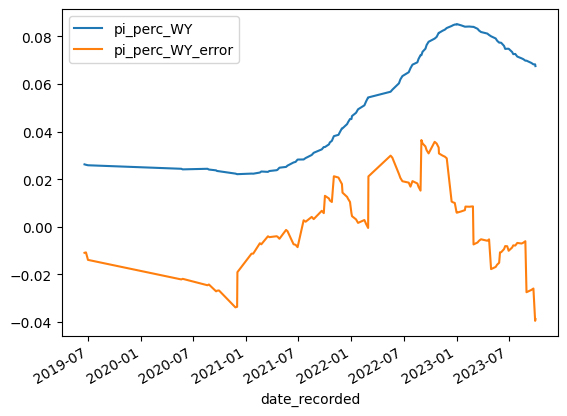

In [23]:
sub[['pi_perc_WY', 'pi_perc_WY_error']].drop_duplicates().plot()

<AxesSubplot: xlabel='date_recorded'>

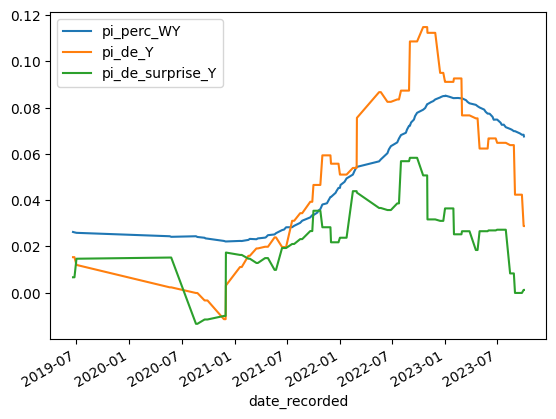

In [17]:
sub[['pi_perc_WY', 'pi_de_Y', 'pi_de_surprise_Y']].drop_duplicates().dropna().plot()

# merge

In [13]:
df = pd_join_dfs(
    [
        pi[['pi_de', 'pi_de_Y', 'pi_de_estimate_Y', 'pi_de_surprise_Y']],
        hhp.set_index('date_recorded')[
            ['date_forecast', 'pi_exp_WY', 'pi_exp_MY', 'pi_perc_MY', 'pi_perc_WY', 'hhinc_delta', 'delta_pe_WY', 'id']
        ],
        bei.set_index('date_forecast')[['bei']],
        gdp[['gdp_cyc']],
        mir,
    ],
    index_name='date_recorded'
)

In [24]:
sub = pd_groupby(df, ['pi_de_surprise_Y', 'pi_de_estimate_Y', 'pi_perc_MY', 'delta_pe_WY'], 'M', 'last').dropna(thresh=1)

In [25]:
for i in sub:
    print(i, f"ADF p-val: {adfuller(sub[i].dropna())[1]}")

pi_de_surprise_Y ADF p-val: 0.3020177714857524
pi_de_estimate_Y ADF p-val: 0.17489657620970406
pi_perc_MY ADF p-val: 0.22733055722493378
delta_pe_WY ADF p-val: 0.5268515073187277


In [27]:
jtest = select_coint_rank(sub, -1, 15, method="maxeig", signif=0.05)
print(jtest.summary())
jtest.rank

Johansen cointegration test using maximum eigenvalue test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          15.05          11.22
  1   2          4.928          4.130
-------------------------------------


2

In [28]:
vecm = VECM(sub, coint_rank=jtest.rank).fit()

C:\Users\LukasGrahl\miniforge3\envs\mamba_env_memoire2\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [29]:
vecm.summary();

In [30]:
sub.columns

Index(['pi_de_surprise_Y', 'pi_perc_MY'], dtype='object')

In [31]:
vecm.test_granger_causality('pi_de_surprise_Y', 'pi_perc_MY', ).summary()

Test statistic,Critical value,p-value,df
11.90,3.145,0.000,"(2, 62)"


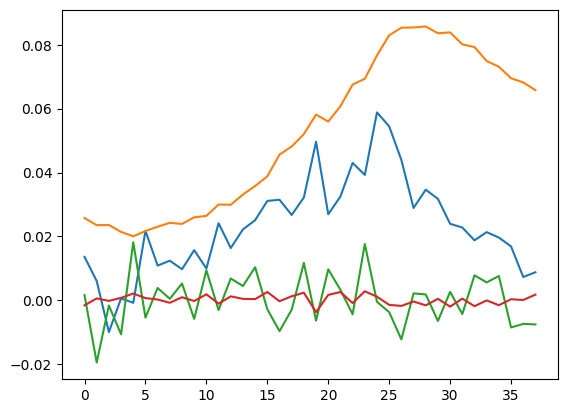

In [32]:
plt.plot(vecm.fittedvalues)
plt.plot(vecm.resid)

In [33]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import normaltest, ttest_1samp

In [35]:
for i in range(vecm.resid.shape[1]):
    print("\n", i, acorr_ljungbox(vecm.resid[:, i], boxpierce=True, model_df=1))


 0     lb_stat  lb_pvalue   bp_stat  bp_pvalue
1  1.472130        NaN  1.361720        NaN
2  2.318970   0.127805  2.123876   0.145019
3  5.897578   0.052403  5.255159   0.072253
4  6.116013   0.106100  5.440828   0.142221
5  6.755200   0.149404  5.968157   0.201539
6  7.002857   0.220428  6.166283   0.290374
7  7.926116   0.243566  6.881808   0.331916

 1     lb_stat  lb_pvalue   bp_stat  bp_pvalue
1  1.245613        NaN  1.152192        NaN
2  1.812204   0.178244  1.662124   0.197317
3  3.749220   0.153415  3.357013   0.186653
4  5.388630   0.145454  4.750511   0.191004
5  5.428849   0.246055  4.783692   0.310221
6  8.463596   0.132469  7.211489   0.205381
7  9.101995   0.167923  7.706249   0.260424


# Exp 3

Aggregate effect of news on inflation expectation